##### *Copyright 2021 Google LLC*
*Licensed under the Apache License, Version 2.0 (the "License")*

In [ ]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Mon Nov  7 00:43:48 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   28C    P0    43W / 400W |      0MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Retrain EfficientDet for the Edge TPU with TensorFlow Lite Model Maker

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Import the required packages

In [ ]:
!pip install -q tflite-model-maker

     |████████████████████████████████| 577 kB 4.7 MB/s 
     |████████████████████████████████| 77 kB 7.8 MB/s 
     |████████████████████████████████| 1.1 MB 75.9 MB/s 
     |████████████████████████████████| 238 kB 91.3 MB/s 
     |████████████████████████████████| 10.9 MB 61.7 MB/s 
     |████████████████████████████████| 128 kB 91.6 MB/s 
     |████████████████████████████████| 840 kB 55.2 MB/s 
     |████████████████████████████████| 3.4 MB 76.8 MB/s 
     |████████████████████████████████| 87 kB 8.8 MB/s 
     |████████████████████████████████| 1.3 MB 75.0 MB/s 
     |████████████████████████████████| 60.9 MB 122.6 MB/s 
     |████████████████████████████████| 25.3 MB 737 kB/s 
     |████████████████████████████████| 497.9 MB 24 kB/s 
     |████████████████████████████████| 352 kB 90.8 MB/s 
     |████████████████████████████████| 1.4 MB 76.6 MB/s 
     |████████████████████████████████| 462 kB 87.8 MB/s 
     |████████████████████████████████| 5.8 MB 82.3 MB/s 
     |██████████

In [ ]:
import numpy as np
import os

from tflite_model_maker.config import ExportFormat
from tflite_model_maker import model_spec
from tflite_model_maker import object_detector

import tensorflow as tf
assert tf.__version__.startswith('2')

tf.get_logger().setLevel('ERROR')
from absl import logging
logging.set_verbosity(logging.ERROR)

## Load the training data


### (Optional) Load your own Pascal VOC dataset

To use your custom dataset, you need to modify a few variables here, such as your ZIP filename, your label map, and the path to your images/annotations:

In [ ]:
# Your labels map as a dictionary (zero is reserved):
label_map = {1: 'CyclistN', 2: 'CyclistNE', 3: 'CyclistE', 4: 'CyclistSE', 5: 'CyclistS', 6:'CyclistWS', 7: 'CyclistW', 8: 'CyclistNW'} 

Now you're ready to train the model with your custom dataset. But before you run the notebook, you should also skip to the [Export to TensorFlow Lite](#scrollTo=_yB_XMpqGlLs) section and change the `TFLITE_FILENAME` and `LABLES_FILENAME` for your exported files.

Then run the whole notebook by clicking **Runtime > Run all**.

In [ ]:
# We need to instantiate a separate DataLoader for each split dataset
os.chdir('/content/drive/My Drive/STEM_1/dataset')
train_data = object_detector.DataLoader(tfrecord_file_patten='/content/drive/My Drive/STEM_1/dataset/train2.record', size=25000, label_map=label_map)
validation_data = object_detector.DataLoader(
      '/content/drive/My Drive/STEM_1/dataset/test2.record', size=1000, label_map=label_map)

## Select the model spec

Model Maker supports the EfficientDet-Lite family of object detection models that are compatible with the Edge TPU. (EfficientDet-Lite is derived from [EfficientDet](https://ai.googleblog.com/2020/04/efficientdet-towards-scalable-and.html), which offers state-of-the-art accuracy in a small model size). There are several model sizes you can choose from:

|| Model architecture | Size(MB)* | Latency(ms)** | Average Precision*** |
|-|--------------------|-----------|---------------|----------------------|
|| EfficientDet-Lite0 | 5.7       | 37.4            | 30.4%               |
|| EfficientDet-Lite1 | 7.6       | 56.3            | 34.3%               |
|| EfficientDet-Lite2 | 10.2      | 104.6           | 36.0%               |
|| EfficientDet-Lite3 | 14.4      | 107.6           | 39.4%               |
| <td colspan=4><br><i>* File size of the compiled Edge TPU models. <br/>** Latency measured on a desktop CPU with a Coral USB Accelerator. <br/>*** Average Precision is the mAP (mean Average Precision) on the COCO 2017 validation dataset.</i></td> |

Beware that the Lite2 and Lite3 models do not fit onto the Edge TPU's onboard memory, so you'll see even greater latency when using those, due to the cost of fetching data from the host system memory. Maybe this extra latency is okay for your application, but if it's not and you require the precision of the larger models, then you can [pipeline the model across multiple Edge TPUs](https://coral.ai/docs/edgetpu/pipeline/) (more about this when we compile the model below).

In [ ]:
spec = object_detector.EfficientDetLite1Spec(model_dir='/content/drive/My Drive', verbose=0)

The [`EfficientDetLite0Spec`](https://www.tensorflow.org/lite/api_docs/python/tflite_model_maker/object_detector/EfficientDetLite0Spec) constructor also supports several arguments that specify training options, such as the max number of detections (default is 25 for the TF Lite model) and whether to use Cloud TPUs for training. You can also use the constructor to specify the number of training epochs and the batch size, but you can also specify those in the next step.

In [ ]:
spec.config.var_freeze_expr = 'efficientnet'

## Create and train the model

Now we need to create our model according to the model spec, load our dataset into the model, specify training parameters, and begin training. 

Using Model Maker, we accomplished all of that with [`create()`](https://www.tensorflow.org/lite/api_docs/python/tflite_model_maker/object_detector/create):

In [ ]:
model = object_detector.create(train_data=train_data, 
                               model_spec=spec, 
                               epochs=15, 
                               batch_size=4, 
                               train_whole_model=False)

Epoch 1/15
6250/6250 [==============================] - ETA: 0s - det_loss: 0.4932 - cls_loss: 0.3963 - box_loss: 0.0019 - reg_l2_loss: 0.0184 - loss: 0.5116 - learning_rate: 0.0065 - gradient_norm: 1.9606
Epoch 1: saving model to /content/drive/My Drive/ckpt-1
6250/6250 [==============================] - 622s 94ms/step - det_loss: 0.4932 - cls_loss: 0.3963 - box_loss: 0.0019 - reg_l2_loss: 0.0184 - loss: 0.5116 - learning_rate: 0.0065 - gradient_norm: 1.9605
Epoch 2/15
6250/6250 [==============================] - ETA: 0s - det_loss: 0.3926 - cls_loss: 0.3253 - box_loss: 0.0013 - reg_l2_loss: 0.0192 - loss: 0.4118 - learning_rate: 0.0049 - gradient_norm: 1.8017
Epoch 2: saving model to /content/drive/My Drive/ckpt-2
6250/6250 [==============================] - 590s 94ms/step - det_loss: 0.3926 - cls_loss: 0.3252 - box_loss: 0.0013 - reg_l2_loss: 0.0192 - loss: 0.4118 - learning_rate: 0.0049 - gradient_norm: 1.8016
Epoch 3/15
6250/6250 [==============================] - ETA: 0s - det_lo

## Evaluate the model

Now we'll use the test dataset to evaluate how well the model performs with data it has never seen before.

The [`evaluate()`](https://www.tensorflow.org/lite/api_docs/python/tflite_model_maker/object_detector/ObjectDetector#evaluate) method provides output in the style of [COCO evaluation metrics](https://cocodataset.org/#detection-eval):

In [ ]:
model.evaluate(validation_data)

12/16 [=====================>........] - ETA: 4s


{'AP': 0.45852143,
 'AP50': 0.56443346,
 'AP75': 0.517839,
 'APs': 0.005194805,
 'APm': 0.20941214,
 'APl': 0.4815102,
 'ARmax1': 0.5119225,
 'ARmax10': 0.7649619,
 'ARmax100': 0.78073084,
 'ARs': 0.4,
 'ARm': 0.49727932,
 'ARl': 0.807394,
 'AP_/CyclistN': 0.64601207,
 'AP_/CyclistNE': 0.23612733,
 'AP_/CyclistE': 0.6230924,
 'AP_/CyclistSE': 0.25653276,
 'AP_/CyclistS': 0.49380535,
 'AP_/CyclistWS': 0.47254133,
 'AP_/CyclistW': 0.4827137,
 'AP_/CyclistNW': 0.45734638}

Because the default batch size for [EfficientDetLite models](https://www.tensorflow.org/lite/api_docs/python/tflite_model_maker/object_detector/EfficientDetSpec) is 64, this needs only 1 step to go through all 25 images in the salad test set. You can also specify the `batch_size` argument when you call [`evaluate()`](https://www.tensorflow.org/lite/api_docs/python/tflite_model_maker/object_detector/ObjectDetector#evaluate).

## Export to TensorFlow Lite

Next, we'll export the model to the TensorFlow Lite format. By default, the [`export()`](https://www.tensorflow.org/lite/api_docs/python/tflite_model_maker/object_detector/ObjectDetector#export) method performs [full integer post-training quantization](https://www.tensorflow.org/lite/performance/post_training_quantization#full_integer_quantization), which is exactly what we need for compatibility with the Edge TPU. (Model Maker uses the same dataset we gave to our model spec as a representative dataset, which is required for full-int quantization.)

We just need to specify the export directory and format. By default, it exports to TF Lite, but we also want a labels file, so we declare both:

In [ ]:
TFLITE_FILENAME = 'efficientdet-lite-bikes.tflite'
LABELS_FILENAME = 'bikes-labels.txt'

In [ ]:
model.export(export_dir='/content/drive/My Drive/STEM_1/dataset/export', tflite_filename=TFLITE_FILENAME, label_filename=LABELS_FILENAME,
             export_format=[ExportFormat.TFLITE, ExportFormat.LABEL])

### Evaluate the TF Lite model

Exporting the model to TensorFlow Lite can affect the model accuracy, due to the reduced numerical precision from quantization and because the original TensorFlow model uses per-class [non-max supression (NMS)](https://www.coursera.org/lecture/convolutional-neural-networks/non-max-suppression-dvrjH) for post-processing, while the TF Lite model uses global NMS, which is faster but less accurate.

Therefore you should always evaluate the exported TF Lite model and be sure it still meets your requirements:

In [ ]:
model.evaluate_tflite("/content/drive/My Drive/STEM_1/dataset/export/"+TFLITE_FILENAME, validation_data)

### Try the TFLite model

Just to be sure of things, let's run the model ourselves with an image from the test set. 

To simplify our code, we'll use the [PyCoral API](https://coral.ai/docs/reference/py/):

In [ ]:
! python3 -m pip install --extra-index-url https://google-coral.github.io/py-repo/ pycoral

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/, https://google-coral.github.io/py-repo/
     |████████████████████████████████| 373 kB 1.8 MB/s 
     |████████████████████████████████| 1.5 MB 57.8 MB/s 


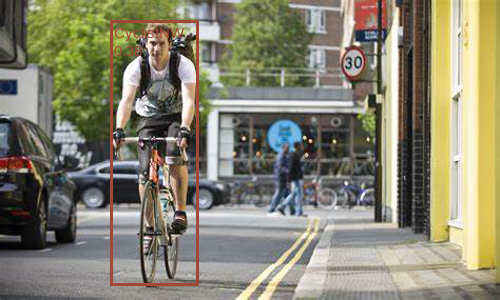

In [ ]:
from PIL import Image
from PIL import ImageDraw
from PIL import ImageFont

import tflite_runtime.interpreter as tflite 
from pycoral.adapters import common
from pycoral.adapters import detect
from pycoral.utils.dataset import read_label_file

def draw_objects(draw, objs, scale_factor, labels):
  """Draws the bounding box and label for each object."""
  COLORS = np.random.randint(0, 255, size=(len(labels), 3), dtype=np.uint8)
  for obj in objs:
    bbox = obj.bbox
    color = tuple(int(c) for c in COLORS[obj.id])
    draw.rectangle([(bbox.xmin * scale_factor, bbox.ymin * scale_factor),
                    (bbox.xmax * scale_factor, bbox.ymax * scale_factor)],
                   outline=color, width=3)
    font = ImageFont.truetype("LiberationSans-Regular.ttf", size=15)
    draw.text((bbox.xmin * scale_factor + 4, bbox.ymin * scale_factor + 4),
              '%s\n%.2f' % (labels.get(obj.id, obj.id), obj.score),
              fill=color, font=font)

# Load the TF Lite model
labels = read_label_file('/content/drive/My Drive/STEM_1/dataset/export/' + LABELS_FILENAME)
interpreter = tflite.Interpreter('/content/drive/My Drive/STEM_1/dataset/export/' + TFLITE_FILENAME)
interpreter.allocate_tensors()

# Resize the image for input
image = Image.open('/content/drive/My Drive/bike2.jpg')
_, scale = common.set_resized_input(
    interpreter, image.size, lambda size: image.resize(size, Image.ANTIALIAS))

# Run inference
interpreter.invoke()
objs = detect.get_objects(interpreter, score_threshold=0.2, image_scale=scale)

# Resize again to a reasonable size for display
display_width = 500
scale_factor = display_width / image.width
height_ratio = image.height / image.width
image = image.resize((display_width, int(display_width * height_ratio)))
draw_objects(ImageDraw.Draw(image), objs, scale_factor, labels)
image

## Compile for the Edge TPU


First we need to download the Edge TPU Compiler:

In [ ]:
! curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | sudo apt-key add -

! echo "deb https://packages.cloud.google.com/apt coral-edgetpu-stable main" | sudo tee /etc/apt/sources.list.d/coral-edgetpu.list

! sudo apt-get update

! sudo apt-get install edgetpu-compiler

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2537  100  2537    0     0   130k      0 --:--:-- --:--:-- --:--:--  130k
OK
deb https://packages.cloud.google.com/apt coral-edgetpu-stable main
Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Get:2 https://packages.cloud.google.com/apt coral-edgetpu-stable InRelease [6,722 B]
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease [1,581 B]
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:6 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ Packages [98.9 kB]
Get:7 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:8 https://packages.cloud.google.com/apt coral-ed

Before compiling the `.tflite` file for the Edge TPU, it's important to consider whether your model will fit into the Edge TPU memory. 

The Edge TPU has approximately 8 MB of SRAM for [caching model paramaters](https://coral.ai/docs/edgetpu/compiler/#parameter-data-caching), so any model close to or over 8 MB will not fit onto the Edge TPU memory. That means the inference times are longer, because some model parameters must be fetched from the host system memory.

One way to elimiate the extra latency is to use [model pipelining](https://coral.ai/docs/edgetpu/pipeline/), which splits the model into segments that can run on separate Edge TPUs in series. This can significantly reduce the latency for big models.

The following table provides recommendations for the number of Edge TPUs to use with each EfficientDet-Lite model.

| Model architecture | Minimum TPUs | Recommended TPUs
|--------------------|-------|-------|
| EfficientDet-Lite0 | 1     | 1     |
| EfficientDet-Lite1 | 1     | 1     |
| EfficientDet-Lite2 | 1     | 2     |
| EfficientDet-Lite3 | 2     | 2     |
| EfficientDet-Lite4 | 2     | 3     |

If you need extra Edge TPUs for your model, then update `NUMBER_OF_TPUS` here:

In [ ]:
TFLITE_FILENAME = '/content/drive/My Drive/STEM_1/dataset/export/efficientdet-lite-bikes.tflite'
NUMBER_OF_TPUS = 1

In [ ]:
!edgetpu_compiler $TFLITE_FILENAME -d --num_segments=$NUMBER_OF_TPUS

Only one input model is supported if num_segments > 1 or search delegate is enabled.


**Beware when using multiple segments:** The Edge TPU Comiler divides the model such that all segments have roughly equal amounts of parameter data, but that does not mean all segments have the same latency. Especially when dividing an SSD model such as EfficientDet, this results in a latency-imbalance between segments, because SSD models have a large post-processing op that actually executes on the CPU, not on the Edge TPU. So although segmenting your model this way is better than running the whole model on just one Edge TPU, we recommend that you segment the EfficientDet-Lite model using our [profiling-based partitioner tool](https://github.com/google-coral/libcoral/tree/master/coral/tools/partitioner#profiling-based-partitioner-for-the-edge-tpu-compiler), which measures each segment's latency on the Edge TPU and then iteratively adjusts the segmentation sizes to provide balanced latency between all segments.

## Download the files

In [ ]:
from google.colab import files
TFLITE_FILENAME = 'efficientdet-lite-bikes.tflite'
files.download(TFLITE_FILENAME)
files.download(TFLITE_FILENAME.replace('.tflite', '_edgetpu.tflite'))
files.download(LABELS_FILENAME)

## Run the model on the Edge TPU

You can now run the model with acceleration on the Edge TPU.

First, download an image of a salad on your device with an Edge TPU. For example, you can use the same one we tested above: 

```
wget https://storage.googleapis.com/cloud-ml-data/img/openimage/3/2520/3916261642_0a504acd60_o.jpg -O salad.jpg
```

And then make sure you have [installed the PyCoral API](https://coral.ai/software/#pycoral-api).

Now run an inference using [this example code for the PyCoral API](https://github.com/google-coral/pycoral/blob/master/examples/detect_image.py). Just clone the GitHub repo and run the example, passing it the model files from this tutorial:

```
git clone https://github.com/google-coral/pycoral

cd pycoral/examples/

python3 detect_image.py \
  --model efficientdet-lite-salads_edgetpu.tflite \
  --labels salad-labels.txt \
  --input salad.jpg \
  --output salad_result.jpg
```


## More resources

* For more information about the Model Maker library used in this tutorial, see the [TensorFlow Lite Model Maker guide](https://www.tensorflow.org/lite/guide/model_maker) and [API reference](https://www.tensorflow.org/lite/api_docs/python/tflite_model_maker).

* For other transfer learning tutorials that are compatible with the Edge TPU, see the [Colab tutorials for Coral](https://github.com/google-coral/tutorials#colab-tutorials-for-coral).

* You can also find more examples that show how to run inference on the Edge TPU at [coral.ai/examples](https://coral.ai/examples/#code-examples/).